In [1]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_ollama import OllamaEmbeddings, OllamaLLM, ChatOllama
from langchain_text_splitters import RecursiveCharacterTextSplitter

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=100
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=OllamaEmbeddings(model="nomic-embed-text"),
)
retriever = vectorstore.as_retriever()

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
retriever.invoke("what is prompt engineering?")

[Document(metadata={'description': 'Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the model weights. It is an empirical science and the effect of prompt engineering methods can vary a lot among models, thus requiring heavy experimentation and heuristics.\nThis post only focuses on prompt engineering for autoregressive language models, so nothing with Cloze tests, image generation or multimodality models. At its core, the goal of prompt engineering is about alignment and model steerability. Check my previous post on controllable text generation.', 'language': 'en', 'source': 'https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/', 'title': "Prompt Engineering | Lil'Log"}, page_content='Filter annotations based on whether API calls help model predict future tokens. Use a self-supervised loss to decide which API calls are actually helpful.\n\n\nExecute each A

In [3]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.",
)

tools = [retriever_tool]

In [4]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [5]:
from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict

from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI

from pydantic import BaseModel, Field


from langgraph.prebuilt import tools_condition
from langchain_core.output_parsers import JsonOutputParser
from langchain.output_parsers import PydanticOutputParser


In [6]:
def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
    model = ChatOllama(model="llama3.2", temperature=0)

    # LLM with tool and validation
    # llm_with_tool = model.with_structured_output(grade)
    parser = PydanticOutputParser(pydantic_object=grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        {format_instructions}
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give only a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
        partial_variables={"format_instructions": parser.get_format_instructions()},
    )

    # Chain
    chain = prompt | model | parser

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})
    print(scored_result)

    score = scored_result.binary_score
    print(score)

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"


In [7]:
grade_documents(state={"messages": [HumanMessage(content="What is prompt engineering?")]})

---CHECK RELEVANCE---
binary_score='yes'
yes
---DECISION: DOCS RELEVANT---


'generate'

In [8]:
### Nodes


def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    model = ChatOllama(model="llama3.2", temperature=0)
    model = model.bind_tools(tools)
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}




In [9]:
agent(state={"messages": [HumanMessage(content="What is prompt engineering?")]})

---CALL AGENT---


{'messages': [AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2024-12-05T17:39:33.1132759Z', 'done': True, 'done_reason': 'stop', 'total_duration': 27186444900, 'load_duration': 64329900, 'prompt_eval_count': 186, 'prompt_eval_duration': 23521000000, 'eval_count': 19, 'eval_duration': 3599000000, 'message': Message(role='assistant', content='', images=None, tool_calls=[ToolCall(function=Function(name='retrieve_blog_posts', arguments={'query': 'prompt engineering'}))])}, id='run-2718ca94-3a73-4b04-9537-5b0efaec379d-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'prompt engineering'}, 'id': 'eaca057d-3691-4a35-b153-64fe23b72cc0', 'type': 'tool_call'}], usage_metadata={'input_tokens': 186, 'output_tokens': 19, 'total_tokens': 205})]}

In [10]:
def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    model = ChatOllama(model="llama3.2", temperature=0)
    response = model.invoke(msg)
    return {"messages": [response]}





In [11]:
def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    llm = OllamaLLM(model="llama3.2", temperature=0)

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}

In [12]:
print("*" * 20 + "Prompt[rlm/rag-prompt]" + "*" * 20)
prompt = hub.pull("rlm/rag-prompt").pretty_print()

********************Prompt[rlm/rag-prompt]********************


d:\GitHub\langgraph-notebooks\.venv\Lib\site-packages\langsmith\client.py:241: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


In [13]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)  # retrieval
workflow.add_node("rewrite", rewrite)  # Re-writing the question
workflow.add_node(
    "generate", generate
)  # Generating a response after we know the documents are relevant
# Call agent node to decide to retrieve or not
workflow.add_edge(START, "agent")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# Compile
graph = workflow.compile()

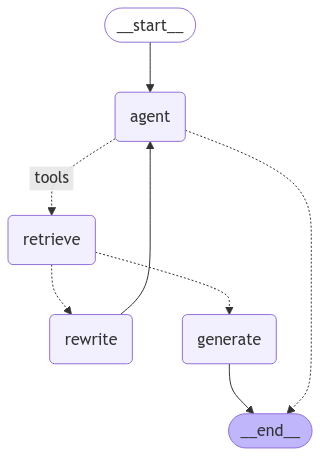

In [14]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [15]:
import pprint

inputs = {
    "messages": [
        ("user", "What does Lilian Weng say about the types of agent memory?"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2024-12-05T17:39:50.4890607Z', 'done': True, 'done_reason': 'stop', 'total_duration': 6774860300, 'load_duration': 26445000, 'prompt_eval_count': 195, 'prompt_eval_duration': 1672000000, 'eval_count': 24, 'eval_duration': 5074000000, 'message': Message(role='assistant', content='', images=None, tool_calls=[ToolCall(function=Function(name='retrieve_blog_posts', arguments={'query': 'Lilian Weng agent memory types'}))])}, id='run-89a729f0-93d6-41b4-a1d7-217e418063f0-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'Lilian Weng agent memory types'}, 'id': 'a9c21864-b5be-454b-975f-0ce5377654a8', 'type': 'tool_call'}], usage_metadata={'input_tokens': 195, 'output_tokens': 24, 'total_tokens': 219})]}
'\n---\n'
---CHECK RELEVANCE---
binary_score='yes'
yes
---DECISION: DOCS RELEVANT---
"Output from node 'retrieve':

d:\GitHub\langgraph-notebooks\.venv\Lib\site-packages\langsmith\client.py:241: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


"Output from node 'generate':"
'---'
{ 'messages': [ 'Lilian Weng discusses two types of memory in the context of '
                'LLM-powered autonomous agents: short-term memory for '
                'in-context learning and long-term memory for retaining and '
                'recalling information over extended periods. Long-term memory '
                'is further divided into maximum inner product search (MIPS) '
                'and vector stores, which provide fast retrieval but have '
                'limited representation power compared to full attention. '
                'These limitations pose challenges in long-term planning and '
                'task decomposition.']}
'\n---\n'
